In [1]:
##Initialization
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
#import PyATMM as ATMM

from PyATMM.uniaxialTransferMatrix import *
from PyATMM.isotropicTransferMatrix import *
from PyATMM.transferMatrix import solve_transfer_matrix


##Define constants that will be used later
hc = 1239.84193 ##ev*nm
c = 299792458.
mu0 = 4. * np.pi * 1e-7
ep0 = 1. / (c**2 * mu0)

## User Inputs 

#### E           - Photon energy (currently working with a single energy scan)

#### theta_start - The start angle for the rocking scan

#### theta_end   - The end angle for the rocking scan

#### numpnts     - The number of points in your theta scan

Q-vector will be calculated from these settings 

In [8]:
##User Input##
#Energy
E = 250. ##eV
#Start angle
theta_start = 1.2 #deg
#End angle
theta_end = 80 #deg
#number of points to simulate
numpnts = 1000


##Initialize user inputs
wl = hc/E * 10 #calc wavelength in A
theta_scan = np.linspace(theta_start,theta_end,numpnts)*np.pi/180
qvals = (4*np.pi/wl) * np.sin(theta_scan)


wls = np.array([wl*1e-10]) ##convert wl to m for later calculations
freq = 2*np.pi * c/wls #Angular frequency

theta_exp = np.pi/2 - theta_scan# np.pi/2 - theta_scan ##Inverted for TMM calculation w/ 0deg --> normal to surface
theta_deg = np.linspace(theta_start,theta_end,numpnts) #for reality checks


## Optical tensor definitions

Create optical tensors for each slab as 2x1 numpy arrays in the form: 

e = (e_o, e_e) 

where e_o is the ordinary component and e_e is the extraordinary 

In [9]:
#define the optical tensor for each layer

##Testing comparison w/ ReMagX fake tensors
Silicon_Tensor = np.array([0.988+ 1j*0.009,0.988+ 1j*0.009])# * ep0 # 

Air_Tensor = np.array([1,1]) # *ep0

epsilon_1_xx = (1.008 + 1j*0.008)
epsilon_1_zz = (1.014 + 1j*0.004) 
epsilon_2_xx = (1.004 + 1j*0.002) 
epsilon_2_zz = (1.010 + 1j*0.002)

Val1 = (0.994973599 + 1j*0.000284496)

#epsilon_1_xx = (1.00086 + 1j*0.0002)
#epsilon_1_zz = (1.00098 + 1j*0.00038) 
##epsilon_2_xx = (1.0038 + 1j*0.00304) 
#epsilon_2_zz = (0.9996 + 1j*0)

epsilon_1 = np.array([epsilon_1_xx,epsilon_1_zz])# * ep0
epsilon_2 = np.array([epsilon_2_xx,epsilon_2_xx])# * ep0


### Create slab model from optical tensors

#### [Surface , Top Layer , ... , Bottom layer, Substrate]

In [10]:
##Consolidate the structure of the film as a multilayer

#epsilon = [Silicon_epsilon,SiO2_epsilon,Air_epsilon]
#epsilon = [Air_epsilon,TCT_epsilon_1pt1,Silicon_epsilon]
#epsilon = [Air_epsilon,Surface_res,TCT_epsilon_res,Silicon_epsilon_res]
#epsilon = [Silicon_epsilon,SiO2_epsilon,Air_epsilon]

#epsilon = [Air_epsilon, Silicon_epsilon]
#epsilon = [Silicon_epsilon,Air_epsilon]

#epsilon = [layer1,layer2,layer3,layer4,layer5]
epsilon = [Air_Tensor, epsilon_1, Silicon_Tensor]

### Assign thickness to each slab

Order follows the slab model defined above. All units in meters

End layers don't seem to matter, I keep them as 'np.inf'

In [11]:
#Define the thicknes and roughness of each layer ##must match the size of the multilayer
#d = np.array([np.inf,500e-10,np.inf])
#d = np.array([np.inf, 15e-10,710e-10, np.inf])
#d = np.array([np.inf, 1e-7, 2.3e-7, 0.1e-7, np.inf])
#d = np.array([np.inf,5e-6,np.inf])
#d = np.array([np.inf,np.inf])

d = np.array([np.inf, 500e-10, np.inf])
r = np.array([0, 0, 0])

#### Generate Transfer Matrix using PyATMM & Calculate reflectivity

In [12]:
#Some initialization
OpticAxis = np.array([0.,0.,1])

nlayers = len(d)
D = np.zeros((4, 4, nlayers), dtype=complex) ##dynamic matrices for each layer
P = np.zeros((4, 4, nlayers), dtype=complex) ##Propogation matrices for each layer
W = np.zeros((4, 4, nlayers), dtype=complex) ##Roughness Matric
g = np.zeros((4, nlayers), dtype=complex)

Reflect_SS = np.zeros(numpnts) ##reflectivity of Spol
Reflect_PP = np.zeros(numpnts) ##reflectivty of Ppol
Reflect_SP = np.zeros(numpnts) ##reflectivity of Spol to Ppol
Reflect_PS = np.zeros(numpnts) ##reflectivity of Ppol to Spol

for j, theta in enumerate(theta_exp):
    kx = (2 * np.pi / wls[0]) * np.sin(theta)
    ky = 0 ##Not worried about any biaxial nature to my matrix
    for i in range(nlayers):
        D[:,:,i] = build_uniaxial_dynamic_matrix(epsilon[i][0], epsilon[i][1], freq[0], kx, ky, OpticAxis)
        g[:,i] = build_uniaxial_transmitted_wavevectors(epsilon[i][0], epsilon[i][1], freq[0], kx, ky, OpticAxis)

    for i in range(1,nlayers-1):
        P[:,:,i] = build_uniaxial_propagation_matrix(epsilon[i][0], epsilon[i][1], freq[0], kx, ky, d[i], OpticAxis)
    for i in range(nlayers):
        eplus = np.exp(-(g[:,i] + g[:,i-1])**2 * r[i]**2 / 2) 
        eminus = np.exp(-(g[:,i] - g[:,i-1])**2 * r[i]**2 / 2)

        W[:,:,i] = [[eminus[0],eplus[1],eminus[2],eplus[3]],
                    [eplus[0],eminus[1],eplus[2],eminus[3]],
                    [eminus[0],eplus[1],eminus[2],eplus[3]],
                    [eplus[0],eminus[1],eplus[2],eminus[3]]
                       ]
    M = np.identity(4, dtype=complex)
    for i in range(1,nlayers-1):
        M = np.dot(M, np.dot((np.dot(np.linalg.inv(D[:,:,i-1]),D[:,:,i]) * W[:,:,i]) , P[:,:,i]))
    M = np.dot(M,(np.dot(np.linalg.inv(D[:,:,-2]),D[:,:,-1]) * W[:,:,-1]))
    
    
    r_ss, r_sp, r_ps, r_pp, t_ss, t_sp, t_ps, t_pp = solve_transfer_matrix(M)
    Reflect_SS[j] = np.abs(r_ss)**2
    Reflect_PP[j] = np.abs(r_pp)**2
    

#### A simple plot

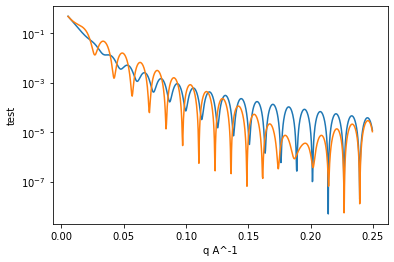

In [13]:
#plot results
plt.plot()
plt.yscale('log')
plt.plot(qvals,Reflect_SS,qvals,Reflect_PP)
plt.ylabel('test')
plt.xlabel('q A^-1')
plt.show()

In [16]:
##Save results
saveQ = qvals.reshape(numpnts,1)
saveRS = Reflect_SS.reshape(numpnts,1)
saveRP = Reflect_PP.reshape(numpnts,1)
np.savetxt('qValsATMM.csv',(saveQ),delimiter=',')
np.savetxt('ReflectSATMM.csv',(saveRS),delimiter=',')
np.savetxt('ReflectPATMM.csv',(saveRP),delimiter=',')

In [28]:
print(Reflect_SS,Reflect_PP)

[1.94518141e-04 9.12576492e-05] [1.10220572e-04 2.77835772e-06]
